In [1]:
import numpy as np
from skimage import data, io, util
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
d = data.coins()
out = np.empty((d.shape[0], d.shape[1]), dtype=np.uint8) # GAP based image
B = np.empty((d.shape[0], d.shape[1]), dtype=np.int16) # predicted context
thre = [5, 15, 25, 42, 60, 85, 140]
N = np.zeros((4 * 256,), dtype=np.int32)
S = np.zeros((4 * 256,), dtype=np.int32)
err_for_del = 0
context = np.empty((d.shape[0], d.shape[1]), dtype=np.uint8) # Final context formation
# Final context formation given by "context" variable

In [3]:
def get(im, i, j):
    if 0 <= i < im.shape[0] and 0 <= j < im.shape[1]:
        return int(im[i, j])
    return 0

In [4]:
def GAP(im, i, j):
    # predicting context
    In = get(im, i, j-1)
    Iw = get(im, i-1, j)
    Ine = get(im, i+1, j-1)
    Inw = get(im, i-1, j-1)
    Inn = get(im, i, j-2)
    Iww = get(im, i-2, j)
    Inne = get(im, i+1, j-2)
    # input to GAP
    dh = abs(Iw - Iww) + abs(In - Inw) + abs(In - Ine)
    dv = abs(Iw - Inw) + abs(In - Inn) + abs(Ine - Inne)
    # GAP
    if dv - dh > 80:
        ic = Iw
    elif dv - dh < -80:
        ic = In
    else:
        ic = (Iw + In) / 2 + (Ine - Inw) / 4
        if dv - dh > 32:
            ic = (ic + Iw) / 2
        elif dv - dh > 8:
            ic = (3*ic + Iw) / 4
        elif dv - dh < -32:
            ic = (ic + In) / 2
        elif dv - dh < -8:
            ic = (3*ic + In) / 4
    #
    
    # Texture Quantizer
    temp = list(map(lambda x: int(x < ic),[(2*Iw)-Iww,(2*In)-Inn,Iww,Inn,Ine,Inw,Iw,In]))
    B = temp[0] << 7 | temp[1] << 6 | temp[2] << 5 | temp[3] << 4 | temp[4] << 3 | temp[5] << 2 | temp[6] << 1 | temp[7]
    
    # Delta.
    global err_for_del
    delt = dh + dv + 2*abs(err_for_del) #Error energy estimator computation
    
    # Error Energy Quantizer
    #   Now quantize error energy estimator according to thresholds given by CALIC
    #   Into 8 partitions
    Qdel = -1
    k = 0
    while k < len(thre):
        if delt <= thre[k]:
            Qdel = k
            break
        k += 1
    if Qdel == -1:
        Qdel = 7
        
    # Context Modeling Context C
    C = B * Qdel // 2
    
    # global err
    # Update N (No of occurrences)
    N[C] += 1
    S[C] += err_for_del
    # Limit the count
    if N[C] == 255:
        N[C] = N[C] / 2
        S[C] = S[C] / 2
    
    ed = S[C] // N[C]
    Itilde = ic + ed
    out[i, j] = Itilde
    context[i, j] = C  # store the context
    err_for_del = get(im, i, j) - Itilde

In [42]:
# Apply GAP to every pixel
for i in range(d.shape[0]):
    for j in range(d.shape[1]):
        GAP(d, i, j)

In [49]:
# Store the un-coded calic raw image.
f = open("coin.craw", "wb")
f.write(N.tobytes())
f.write(S.tobytes())
f.write(context.tobytes())
f.close()

In [50]:
# Store the raw image
f = open("coin.raw", "wb")
f.write(d.tobytes())
f.close()

In [51]:
# Apply arithmetic coding to compress it
import adaptive_arithmetic_compress
adaptive_arithmetic_compress.main(["coin.craw", "coin.calic"])

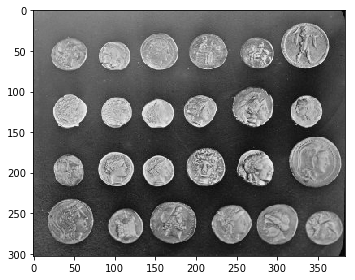

In [52]:
io.imshow(d)
io.show()

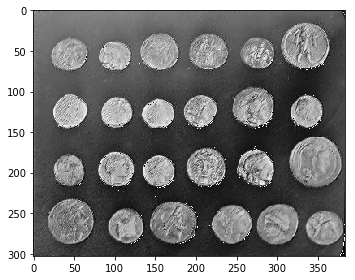

In [53]:
io.imshow(out)
io.show()

In [45]:
# Save the actual image to compare results.
io.imsave("coin.tiff", d)